In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 12.4 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 2.15 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 679 µs


### Database ERD

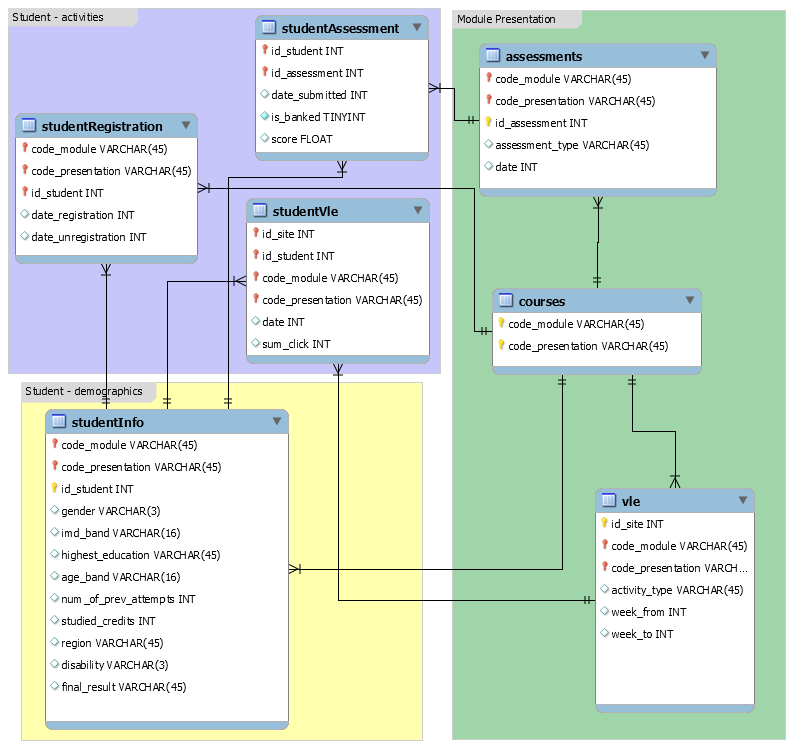

time: 5.11 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.77 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.74 ms


# STUDENTINFO Data

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 4.22 ms


## Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info_full()

time: 324 ms


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                32593 non-null  int64 
 1   row_id                32593 non-null  object
 2   code_module           32593 non-null  object
 3   code_presentation     32593 non-null  object
 4   id_student            32593 non-null  object
 5   gender                32593 non-null  object
 6   region                32593 non-null  object
 7   highest_education     32593 non-null  object
 8   imd_band              31482 non-null  object
 9   age_band              32593 non-null  object
 10  num_of_prev_attempts  32593 non-null  int64 
 11  studied_credits       32593 non-null  int64 
 12  disability            32593 non-null  object
 13  final_result          32593 non-null  object
dtypes: int64(3), object(11)
memory usage: 3.5+ MB
time: 34 ms


In [11]:
df.head()

,target,row_id,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,0,AAA2013J11391,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,0,AAA2013J28400,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,1,AAA2013J30268,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,0,AAA2013J31604,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,0,AAA2013J32885,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


time: 19.7 ms


In [12]:
df = db.sql_fixes(df)

time: 23.2 ms


In [13]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'studied_credits']

time: 997 µs


In [14]:
df = db.cleaner_studentinfo(df, drops)

time: 73.9 ms


In [15]:
df.target.value_counts(normalize=True)

1    0.531724
0    0.468276
Name: target, dtype: float64

time: 6.49 ms


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31144 non-null  int64   
 1   gender                31144 non-null  object  
 2   region                31144 non-null  object  
 3   highest_education     31144 non-null  object  
 4   imd_band              31144 non-null  object  
 5   age_band              31144 non-null  object  
 6   num_of_prev_attempts  31144 non-null  int64   
 7   disability            31144 non-null  object  
 8   course_load           31144 non-null  category
dtypes: category(1), int64(2), object(6)
memory usage: 2.2+ MB
time: 25.5 ms


## Creating Holdout Data

In [17]:
# splitting data & target
X, y = f.X_y(df)

time: 4.06 ms


In [18]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 19 ms


## Creating Training Data

In [19]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 22.3 ms


## Baseline Model: Dummy Classifier

In [20]:
dummy = DummyClassifier(strategy='most_frequent')

time: 890 µs


In [21]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 1.34 ms


### Fitting Model

In [22]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 98.3 ms


### Saving Model

In [23]:
# f.pickle_model(baseline, 'baseline')

time: 900 µs


### Cross Val Scores

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5317387933630273
 Baseline has an average F1 of 0.6942943448460349
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.5317387933630273
time: 321 ms


### Test Data Confusion Matrix

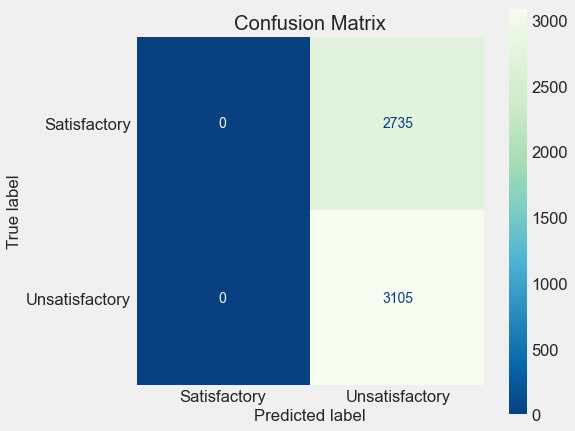

,Accuracy,F1,Recall,Precision
0,0.531678,0.694243,1.0,0.531678


time: 468 ms


In [25]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## First Simple Model: Naive Bayes Classifier

In [26]:
mnb = MultinomialNB()

time: 943 µs


In [27]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.04 ms


### Fitting Model

In [28]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('multinomialnb', MultinomialNB())])

time: 80.5 ms


### Saving Model

In [29]:
# f.pickle_model(fsm, 'fsm')

time: 830 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.5853974805678629
 fsm has an average F1 of 0.6304744503985316
 fsm has an average Recall of 0.6651637144390768
 fsm has an average Precision of 0.5992823091166359


[0.5853974805678629,
 0.6304744503985316,
 0.6651637144390768,
 0.5992823091166359]

time: 376 ms


### Test Data Confusion Matrix

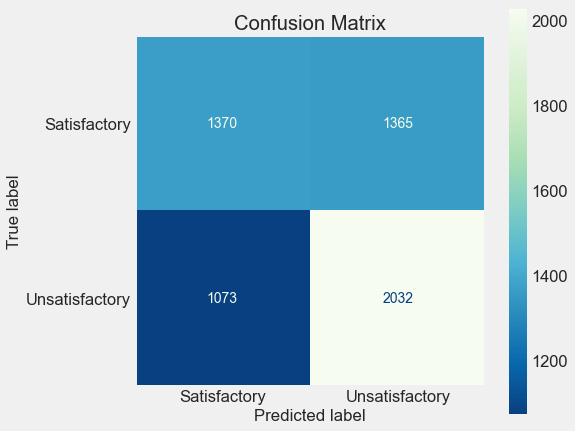

,Accuracy,F1,Recall,Precision
0,0.582534,0.625038,0.654428,0.598175


time: 454 ms


In [31]:
f.confusion_report(fsm, X_test, y_test)

## KNeighborsClassifier

In [32]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 1.07 ms


In [33]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 1.23 ms


### Fitting Model

In [34]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 71.7 ms


In [35]:
# f.pickle_model(knn, 'knn')

time: 783 µs


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5473796595742463
knn has an average F1 of 0.5781514112120285
knn has an average Recall of 0.5833601717659689
knn has an average Precision of 0.573258447324551


[0.5473796595742463, 0.5781514112120285, 0.5833601717659689, 0.573258447324551]

time: 10.9 s


### Test Data Confusion Matrix

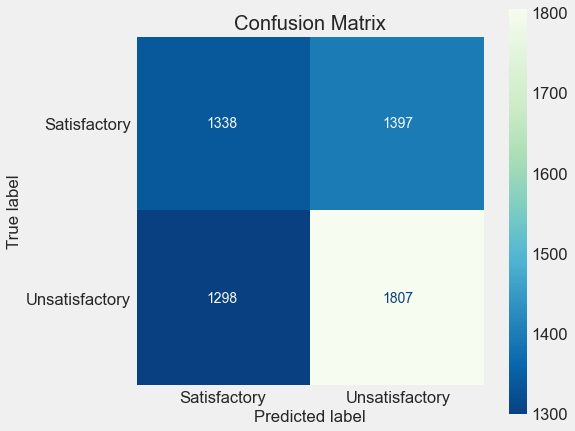

,Accuracy,F1,Recall,Precision
0,0.538527,0.572832,0.581965,0.563983


time: 23.3 s


In [37]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [38]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 1.49 ms


In [39]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 1.38 ms


### Fitting Model

In [40]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.28 s


In [41]:
# f.pickle_model(logreg, 'logreg')

time: 999 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.5881378420584051
logreg has an average F1 of 0.6347719400680819
logreg has an average Recall of 0.6731078904991948
logreg has an average Precision of 0.6006268985152368


[0.5881378420584051,
 0.6347719400680819,
 0.6731078904991948,
 0.6006268985152368]

time: 4.13 s


### Test Data Confusion Matrix

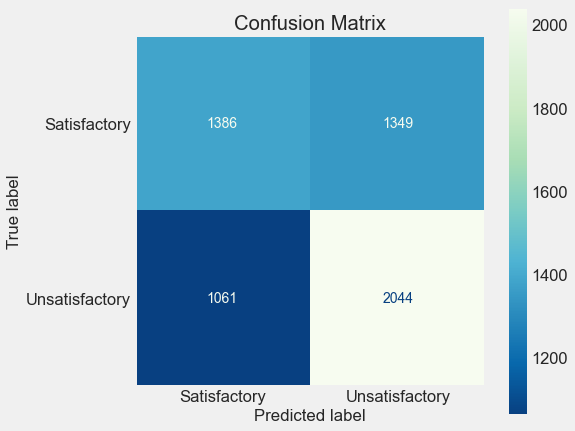

,Accuracy,F1,Recall,Precision
0,0.587329,0.629117,0.658293,0.602417


time: 292 ms


In [43]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [44]:
SVC = SVC()

time: 997 µs


In [45]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 1.15 ms


### Fitting Model

In [46]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('svc', SVC())])

time: 21.1 s


In [47]:
# f.pickle_model(svc, 'svc')

time: 1.29 ms


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.5862538404785461
svc has an average F1 of 0.6333514871177801
svc has an average Recall of 0.6722490606548578
svc has an average Precision of 0.598869767995082


[0.5862538404785461, 0.6333514871177801, 0.6722490606548578, 0.598869767995082]

time: 1min 23s


### Test Data Confusion Matrix

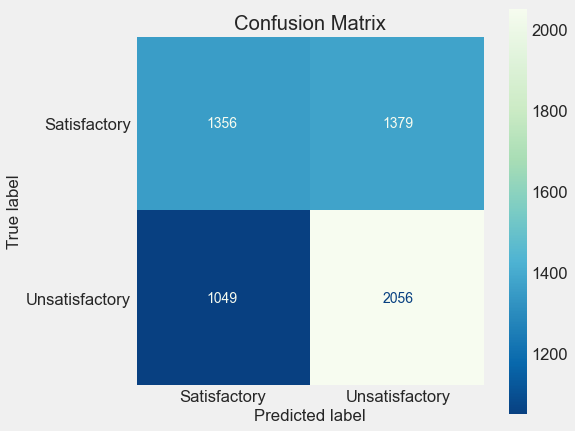

,Accuracy,F1,Recall,Precision
0,0.584247,0.628746,0.662158,0.598544


time: 26.1 s


In [49]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [50]:
LSVC = LinearSVC()

time: 7.22 ms


In [51]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 1.53 ms


### Fitting Model

In [52]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('linearsvc', LinearSVC())])

time: 287 ms


In [53]:
# f.pickle_model(lsvc, 'lsvc')

time: 950 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.5879095641439758
lsvc has an average F1 of 0.6342005253547821
lsvc has an average Recall of 0.6718196457326892
lsvc has an average Precision of 0.6006246607968653


[0.5879095641439758,
 0.6342005253547821,
 0.6718196457326892,
 0.6006246607968653]

time: 1.46 s


### Test Data Confusion Matrix

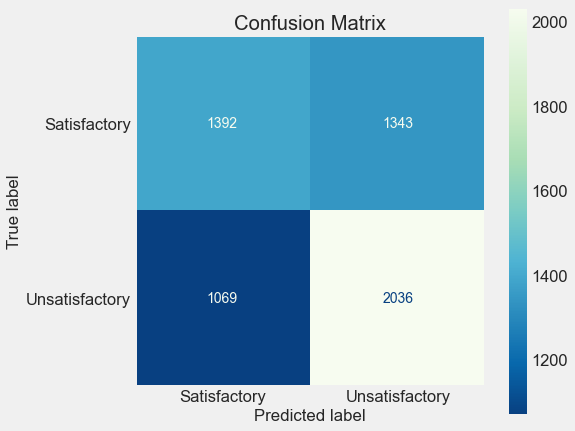

,Accuracy,F1,Recall,Precision
0,0.586986,0.628007,0.655717,0.602545


time: 287 ms


In [55]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [56]:
DT = DecisionTreeClassifier(random_state=2021)

time: 4.48 ms


In [57]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 1.2 ms


### Fitting Model

In [58]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 277 ms


In [59]:
# f.pickle_model(dt, 'dt')

time: 850 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5532018706731479
dt has an average F1 of 0.5748150762120996
dt has an average Recall of 0.5682232957595277
dt has an average Precision of 0.5817330458653753


[0.5532018706731479,
 0.5748150762120996,
 0.5682232957595277,
 0.5817330458653753]

time: 1.7 s


### Test Data Confusion Matrix

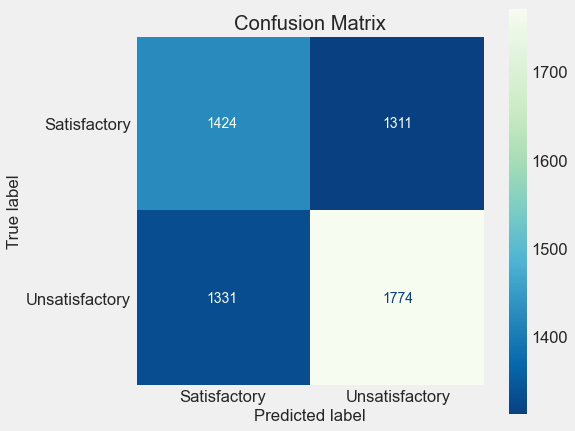

,Accuracy,F1,Recall,Precision
0,0.547603,0.573183,0.571337,0.575041


time: 324 ms


In [61]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [62]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 1.13 ms


In [63]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 945 µs


### Fitting Model

In [64]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 1.88 s


In [65]:
# f.pickle_model(bclf, 'bclf')

time: 755 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5532024735484391
bclf has an average F1 of 0.5988541080007854
bclf has an average Recall of 0.6273752012882448
bclf has an average Precision of 0.5729585359794639


[0.5532024735484391,
 0.5988541080007854,
 0.6273752012882448,
 0.5729585359794639]

time: 7.59 s


### Test Data Confusion Matrix

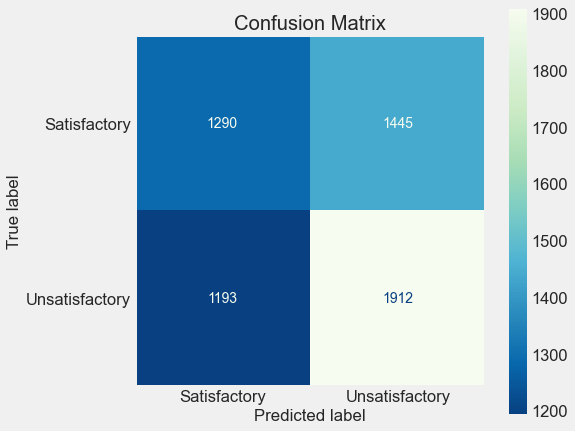

,Accuracy,F1,Recall,Precision
0,0.548288,0.591767,0.615781,0.569556


time: 415 ms


In [67]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [68]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 1.16 ms


In [69]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 978 µs


### Fitting Model

In [70]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.21 s


In [71]:
# f.pickle_model(rf, 'rf')

time: 910 µs


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5553142479309973
rf has an average F1 of 0.6003924318643543
rf has an average Recall of 0.628341384863124
rf has an average Precision of 0.5748867257588556


[0.5553142479309973, 0.6003924318643543, 0.628341384863124, 0.5748867257588556]

time: 16 s


### Test Data Confusion Matrix

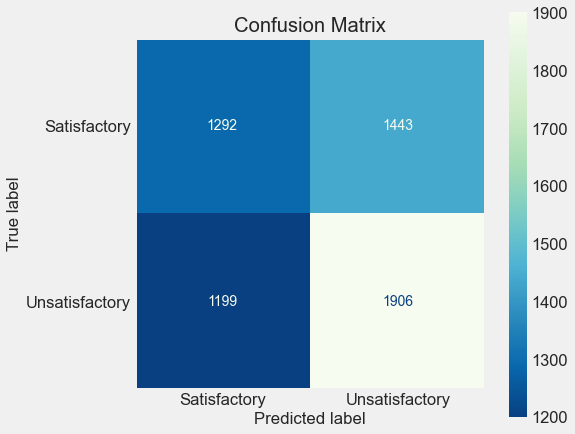

,Accuracy,F1,Recall,Precision
0,0.547603,0.590641,0.613849,0.569125


time: 679 ms


In [73]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [74]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 1.51 ms


In [75]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.38 ms


### Fitting Model

In [76]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.44 s


In [77]:
# f.pickle_model(ada, 'ada')

time: 843 µs


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.5548578387474793
ada has an average F1 of 0.6052569163848175
ada has an average Recall of 0.6420826623725173
ada has an average Precision of 0.572620544267312


[0.5548578387474793, 0.6052569163848175, 0.6420826623725173, 0.572620544267312]

time: 6.06 s


### Test Data Confusion Matrix

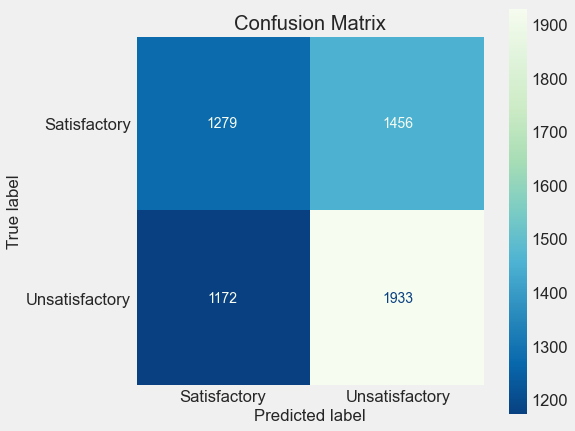

,Accuracy,F1,Recall,Precision
0,0.55,0.595319,0.622544,0.570375


time: 520 ms


In [79]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [80]:
XGB = XGBClassifier(use_label_encoder=False)

time: 1.31 ms


In [81]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 1.29 ms


### Fitting Model

In [82]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 1.19 s


In [83]:
# f.pickle_model(xgb, 'xgb')

time: 748 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

[0.5623928185495277,
 0.6070381993236268,
 0.6359634997316157,
 0.5808108916927115]

time: 5.57 s


### Test Data Confusion Matrix

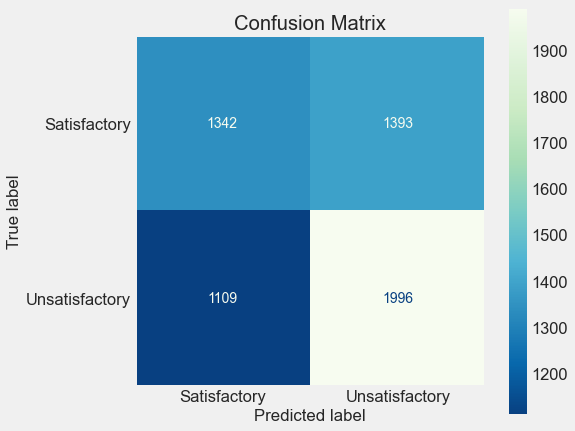

,Accuracy,F1,Recall,Precision
0,0.571575,0.614721,0.642834,0.588964


time: 520 ms


In [85]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
10,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
5,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
6,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier
7,lsvc,0.587910,0.634201,0.671820,0.600625,1.448784,Linear SVC
8,logreg,0.588138,0.634772,0.673108,0.600627,4.121862,Logistic Regression


time: 11.7 ms


# Adding STUDENTVLE Features
<font size=4>(click_sum, num_activities)</font>

In [87]:
df = db.student_info_vle_full()

time: 47 s


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                29228 non-null  int64 
 1   row_id                29228 non-null  object
 2   code_module           29228 non-null  object
 3   code_presentation     29228 non-null  object
 4   id_student            29228 non-null  object
 5   id_site               29228 non-null  object
 6   date                  29228 non-null  object
 7   sum_click             29228 non-null  object
 8   code_module           29228 non-null  object
 9   code_presentation     29228 non-null  object
 10  id_student            29228 non-null  object
 11  gender                29228 non-null  object
 12  region                29228 non-null  object
 13  highest_education     29228 non-null  object
 14  imd_band              28174 non-null  object
 15  age_band              29228 non-null

In [89]:
drops = ['row_id', 'code_module', 'code_presentation', 'studied_credits',
         'id_student', 'id_site', 'date', 'sum_click', 'final_result']

df = db.pipe_cleaner(df, drops)

time: 165 ms


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26470 entries, 0 to 29227
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   target                26470 non-null  int64 
 1   gender                26470 non-null  object
 2   region                26470 non-null  object
 3   highest_education     26470 non-null  object
 4   imd_band              26470 non-null  object
 5   age_band              26470 non-null  object
 6   num_of_prev_attempts  26470 non-null  int64 
 7   disability            26470 non-null  object
 8   click_sum             26470 non-null  int64 
 9   num_activities        26470 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.2+ MB
time: 21.2 ms


In [91]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,click_sum,num_activities
0,0,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,744,243
1,0,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,4104,913
2,0,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,1944,781
3,0,Male,London Region,HE Qualification,60-70%,0-35,0,No,1150,313
4,0,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,1896,572


time: 15.3 ms


In [92]:
df.describe()

,target,num_of_prev_attempts,click_sum,num_activities
count,26470.000000,26470.000000,26470.000000,26470.000000
mean,0.469890,0.144125,1338.822629,360.084133
std,0.499102,0.452979,1719.149524,375.345601
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,259.000000,93.000000
50%,0.000000,0.000000,731.500000,239.000000
75%,1.000000,0.000000,1740.000000,500.000000
max,1.000000,6.000000,24139.000000,2953.000000


time: 43.4 ms


## Creating Holdout Data

In [93]:
# splitting data & target
X, y = f.X_y(df)

time: 22.3 ms


In [94]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 56.1 ms


## Creating Training Data

In [95]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 29.4 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [96]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 3.43 ms


### Fitting Model

In [97]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('multinomialnb', MultinomialNB())])

time: 119 ms


### Saving Model

In [98]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 750 µs


### Cross Val Scores

In [99]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi',\
                'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6511515529965238
 mnb_svsi has an average F1 of 0.6004921499760085
 mnb_svsi has an average Recall of 0.5580313489226999
 mnb_svsi has an average Precision of 0.6499920377587581


[0.6511515529965238,
 0.6004921499760085,
 0.5580313489226999,
 0.6499920377587581]

time: 470 ms


### Test Data Confusion Matrix

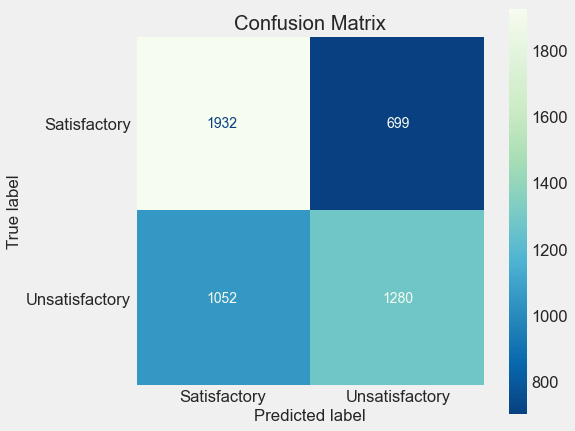

,Accuracy,F1,Recall,Precision
0,0.647189,0.59383,0.548885,0.646791


time: 356 ms


In [100]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [101]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 2.75 ms


### Fitting Model

In [102]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 82.8 ms


In [103]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 874 µs


### Cross Val Scores

In [104]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi',\
                'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.6838607745570304
knn_svsi has an average F1 of 0.6586426638627266
knn_svsi has an average Recall of 0.6490860818952313
knn_svsi has an average Precision of 0.6684974392837131


[0.6838607745570304,
 0.6586426638627266,
 0.6490860818952313,
 0.6684974392837131]

time: 9.54 s


### Test Data Confusion Matrix

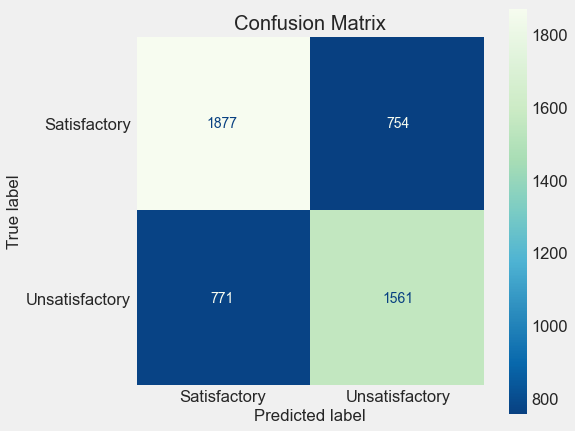

,Accuracy,F1,Recall,Precision
0,0.692726,0.671831,0.669383,0.674298


time: 25.3 s


In [105]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [106]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 2.64 ms


### Fitting Model

In [107]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 514 ms


In [108]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 856 µs


### Cross Val Scores

In [109]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi',\
                'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.7752698153946318
logreg_svsi has an average F1 of 0.7713370572078657
logreg_svsi has an average Recall of 0.806604002859185
logreg_svsi has an average Precision of 0.7391091970077099


[0.7752698153946318, 0.7713370572078657, 0.806604002859185, 0.7391091970077099]

time: 1.79 s


### Test Data Confusion Matrix

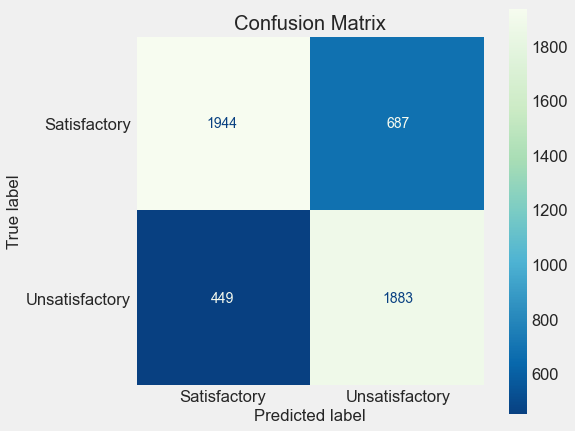

,Accuracy,F1,Recall,Precision
0,0.771106,0.768258,0.807461,0.732685


time: 357 ms


In [110]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [111]:
svc_svsi = make_pipeline(preprocessing_mm, SVC)

time: 1.48 ms


### Fitting Model

In [112]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('svc', SVC())])

time: 25.1 s


In [113]:
# f.pickle_model(svc, 'svc_svsi')

time: 2.62 ms


### Cross Val Scores

In [114]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi',\
                'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.7586804182412148
svc_svsi has an average F1 of 0.755314293594922
svc_svsi has an average Recall of 0.7925952210762789
svc_svsi has an average Precision of 0.7214731939685197


[0.7586804182412148, 0.755314293594922, 0.7925952210762789, 0.7214731939685197]

time: 1min 2s


### Test Data Confusion Matrix

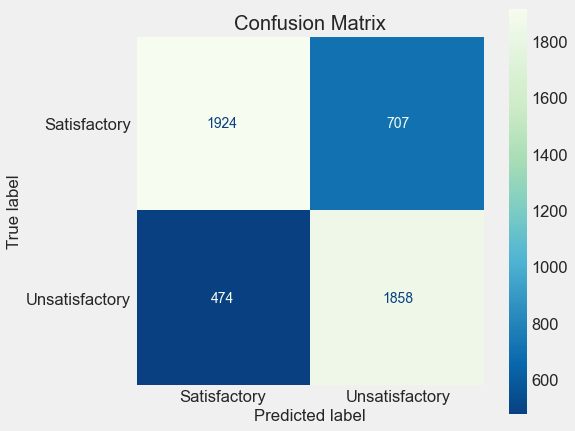

,Accuracy,F1,Recall,Precision
0,0.762039,0.758832,0.796741,0.724366


time: 22.6 s


In [115]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [116]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 3.41 ms


### Fitting Model

In [117]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('linearsvc', LinearSVC())])

time: 533 ms


In [118]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 2.18 ms


### Cross Val Scores

In [119]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi',\
                'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.7711732641092341
lsvc_svsi has an average F1 of 0.7707348320961438
lsvc_svsi has an average Recall of 0.818611048708261
lsvc_svsi has an average Precision of 0.728228844792579


[0.7711732641092341, 0.7707348320961438, 0.818611048708261, 0.728228844792579]

time: 2.09 s


### Test Data Confusion Matrix

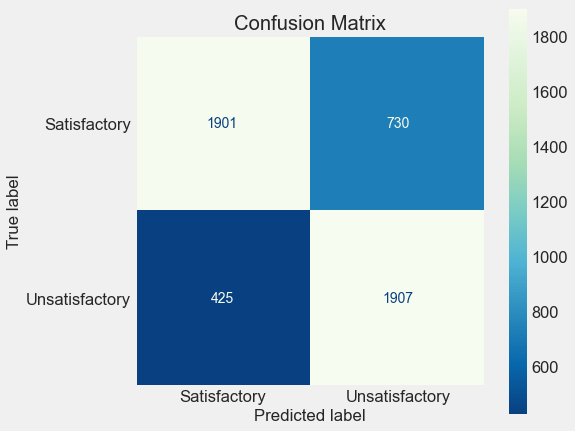

,Accuracy,F1,Recall,Precision
0,0.767278,0.767559,0.817753,0.72317


time: 500 ms


In [120]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [121]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 1.98 ms


### Fitting Model

In [122]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 1.13 s


In [123]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 2.07 ms


### Cross Val Scores

In [124]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi',\
                'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.713815725802904
dt_svsi has an average F1 of 0.6972835816297781
dt_svsi has an average Recall of 0.7015451853364648
dt_svsi has an average Precision of 0.6931909683478993


[0.713815725802904, 0.6972835816297781, 0.7015451853364648, 0.6931909683478993]

time: 5 s


### Test Data Confusion Matrix

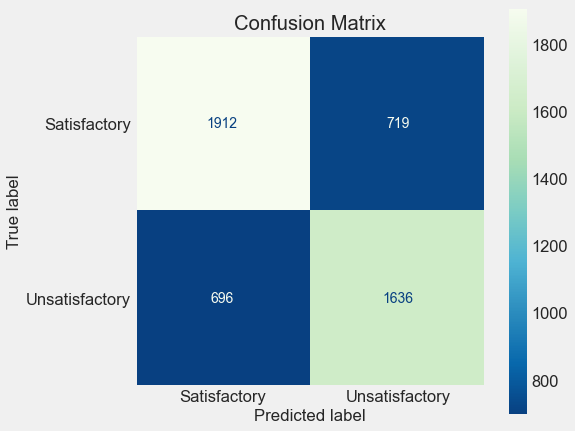

,Accuracy,F1,Recall,Precision
0,0.71489,0.698101,0.701544,0.694692


time: 416 ms


In [125]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [126]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 2.73 ms


### Fitting Model

In [127]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 6.03 s


In [128]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 1.31 ms


### Cross Val Scores

In [129]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi',\
                'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.7640543472645553
bclf_svsi has an average F1 of 0.7292893009821926
bclf_svsi has an average Recall of 0.6765289492494639
bclf_svsi has an average Precision of 0.791078275378512


[0.7640543472645553, 0.7292893009821926, 0.6765289492494639, 0.791078275378512]

time: 21.7 s


### Test Data Confusion Matrix

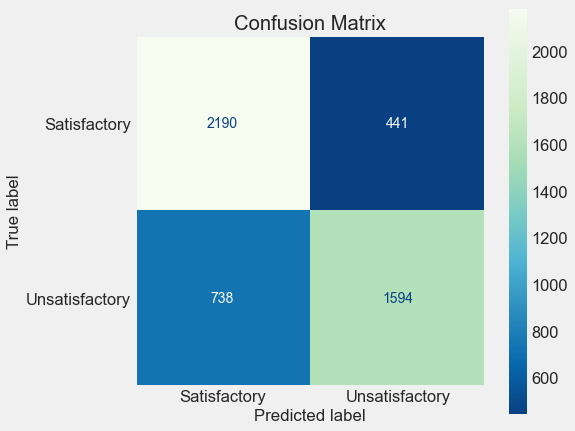

,Accuracy,F1,Recall,Precision
0,0.762442,0.730021,0.683533,0.783292


time: 594 ms


In [130]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [131]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 1.4 ms


### Fitting Model

In [132]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 4.37 s


In [133]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 1.22 ms


### Cross Val Scores

In [134]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi',\
                'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.7768826054598575
rf_svsi has an average F1 of 0.7498473690552829
rf_svsi has an average Recall of 0.7118373327887266
rf_svsi has an average Precision of 0.792230079562219


[0.7768826054598575, 0.7498473690552829, 0.7118373327887266, 0.792230079562219]

time: 16.1 s


### Test Data Confusion Matrix

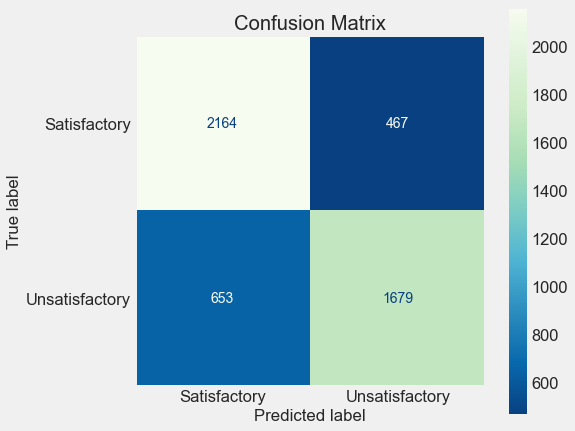

,Accuracy,F1,Recall,Precision
0,0.77433,0.749888,0.719983,0.782386


time: 770 ms


In [135]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [136]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 2.3 ms


### Fitting Model

In [137]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 727 ms


In [138]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 867 µs


### Cross Val Scores

In [139]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi',\
                'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7134796366952998
ada_svsi has an average F1 of 0.696720016390799
ada_svsi has an average Recall of 0.7005452874502195
ada_svsi has an average Precision of 0.6930858638492422


[0.7134796366952998, 0.696720016390799, 0.7005452874502195, 0.6930858638492422]

time: 2.82 s


### Test Data Confusion Matrix

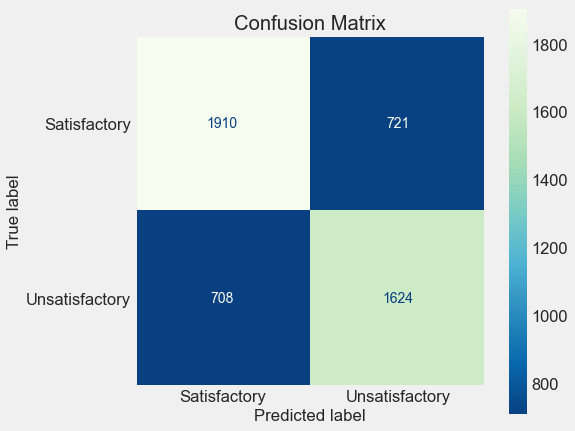

,Accuracy,F1,Recall,Precision
0,0.712069,0.694462,0.696398,0.692537


time: 346 ms


In [140]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [141]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 4.14 ms


### Fitting Model

In [142]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 2.12 s


In [143]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 787 µs


### Cross Val Scores

In [144]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi',\
                'XGBoost SVSI/MinMax()')

[0.7804414322205636,
 0.7525015005622014,
 0.7102636577146941,
 0.8001568893894099]

time: 9.83 s


### Test Data Confusion Matrix

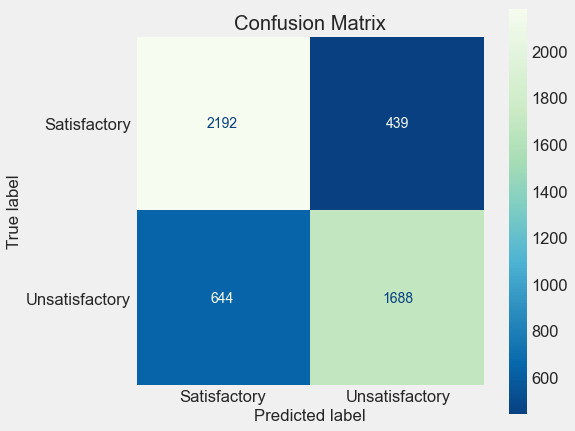

,Accuracy,F1,Recall,Precision
0,0.781785,0.75712,0.723842,0.793606


time: 537 ms


In [145]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [146]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
6,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
7,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
8,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier
9,lsvc,0.587910,0.634201,0.671820,0.600625,1.448784,Linear SVC


time: 20.3 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [147]:
clf1 = LR
clf2 = SVC
clf3 = XGB

estimators = [('logreg', clf1), ('scv', clf2), ('lsvc',clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.25 ms


In [148]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.31 ms


### Fitting Model

In [149]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 13.4 s


In [150]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 747 µs


### Cross Val Scores

In [151]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi',\
                'Voting CLF SVSI/MinMax()')

[0.7786279993493885, 0.769956071630871, 0.7883076687429798, 0.7525339045876993]

time: 55.7 s


### Test Data Confusion Matrix

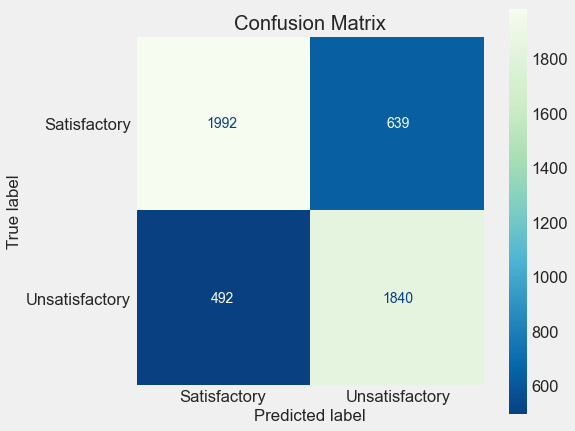

,Accuracy,F1,Recall,Precision
0,0.772114,0.764914,0.789022,0.742235


time: 19.2 s


In [152]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [153]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
6,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
7,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
8,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier
9,lsvc,0.587910,0.634201,0.671820,0.600625,1.448784,Linear SVC


time: 27.8 ms


## Neural Network

### Create Model

In [154]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=38, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.91 ms


In [155]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 2.19 ms


### Pipeline

In [156]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 1.34 ms


### Fitting Models

In [157]:
# %%capture --no-display
nn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1d11e0a00>)])

time: 11.8 s


In [158]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 956 µs


### Cross Val Scores

In [159]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi',\
                'Neural Net SVSI/MinMax()')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


[0.7827924091416778,
 0.7596100069266996,
 0.7325428216401066,
 0.7937929673345584]

time: 36.4 s


### Test Data Confusion Matrix

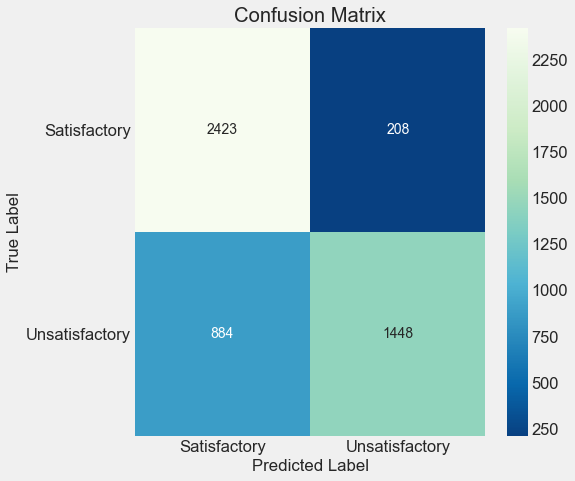

,Accuracy,F1,Recall,Precision
0,0.779972,0.726179,0.620926,0.874396


time: 1.15 s


In [160]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [161]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
6,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
7,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
8,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier
9,lsvc,0.587910,0.634201,0.671820,0.600625,1.448784,Linear SVC


time: 15.7 ms


In [162]:
%%capture --no-display
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 1.02 ms


# Adding Assessment Data Features
<font size=4>(mean_score, median_score, weighted_ave)</font>

In [163]:
df = db.data_prep_full()

time: 23.6 s


In [164]:
# path = os.path.join(gparent, 'data/processed/df2.csv')
# df = pd.read_csv(path)

time: 666 µs


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26331 entries, 0 to 26330
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                26331 non-null  int64  
 1   row_id                26331 non-null  object 
 2   gender                26331 non-null  object 
 3   region                26331 non-null  object 
 4   highest_education     26331 non-null  object 
 5   imd_band              25326 non-null  object 
 6   age_band              26331 non-null  object 
 7   num_of_prev_attempts  26331 non-null  int64  
 8   studied_credits       26331 non-null  int64  
 9   disability            26331 non-null  object 
 10  final_result          26331 non-null  object 
 11  date_sub              26331 non-null  int64  
 12  course_length         26331 non-null  int64  
 13  weighted_ave          26312 non-null  float64
 14  mean_score            26312 non-null  float64
 15  median_score       

In [166]:
df.weighted_ave.describe()

count    26312.000000
mean       251.356656
std        216.520394
min          0.000000
25%         76.175000
50%        240.000000
75%        336.835000
max       1908.760000
Name: weighted_ave, dtype: float64

time: 7.68 ms


In [167]:
drops = ['row_id', 'sum_click', 'date', 'max_date', 'date_sub',
         'course_length','id_site', 'studied_credits', 'final_result']

time: 895 µs


In [168]:
# %%capture --no-display
df = db.pipe_cleaner_wa(df, drops)

time: 98.7 ms


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21642 entries, 1 to 26330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                21642 non-null  int64   
 1   gender                21642 non-null  object  
 2   region                21642 non-null  object  
 3   highest_education     21642 non-null  object  
 4   imd_band              21642 non-null  object  
 5   age_band              21642 non-null  object  
 6   num_of_prev_attempts  21642 non-null  int64   
 7   disability            21642 non-null  object  
 8   weighted_ave          21642 non-null  float64 
 9   mean_score            21642 non-null  float64 
 10  median_score          21642 non-null  float64 
 11  sum_activity          21642 non-null  int64   
 12  activity_level        21642 non-null  category
 13  course_load           21642 non-null  category
dtypes: category(2), float64(3), int64(3), object(6)
memory

In [170]:
df.weighted_ave.describe()

count    21642.000000
mean       219.767088
std        174.246558
min          0.000000
25%         62.970000
50%        219.600000
75%        317.000000
max        729.660000
Name: weighted_ave, dtype: float64

time: 6.56 ms


## Creating Holdout Data

In [171]:
# splitting data & target
X, y = f.X_y(df)

time: 7.4 ms


In [172]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 15.9 ms


## Creating Training Data

In [173]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 13.2 ms


## Naive Bayes Classifier

In [174]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 1.07 ms


### Fitting Model

In [175]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('multinomialnb', MultinomialNB())])

time: 73.1 ms


### Saving Model

In [176]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 885 µs


### Cross Val Scores

In [177]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes ASSESS/MinMax()')

mnb_assess has an average Accuracy of 0.6922693734719806
mnb_assess has an average F1 of 0.6051258883284321
mnb_assess has an average Recall of 0.5261228230980752
mnb_assess has an average Precision of 0.7122363482723008


[0.6922693734719806,
 0.6051258883284321,
 0.5261228230980752,
 0.7122363482723008]

time: 319 ms


### Test Data Confusion Matrix

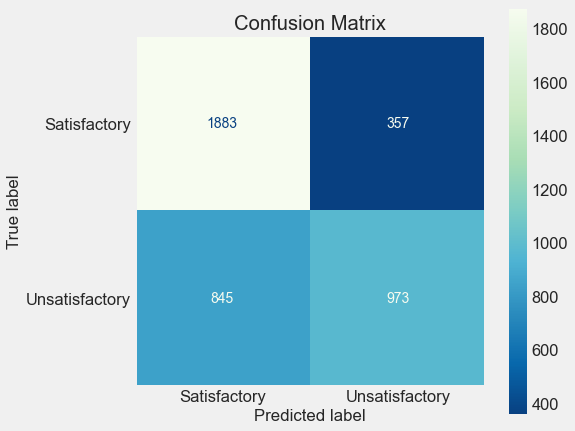

,Accuracy,F1,Recall,Precision
0,0.703795,0.61817,0.535204,0.731579


time: 250 ms


In [178]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [179]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 986 µs


### Fitting Model

In [180]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 69.7 ms


In [181]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 788 µs


### Cross Val Scores

In [182]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN ASSESS/MinMax()')

knn_assess has an average Accuracy of 0.6874230063828819
knn_assess has an average F1 of 0.6411421867836287
knn_assess has an average Recall of 0.6232813932172319
knn_assess has an average Precision of 0.6601698636935284


[0.6874230063828819,
 0.6411421867836287,
 0.6232813932172319,
 0.6601698636935284]

time: 5.04 s


### Test Data Confusion Matrix

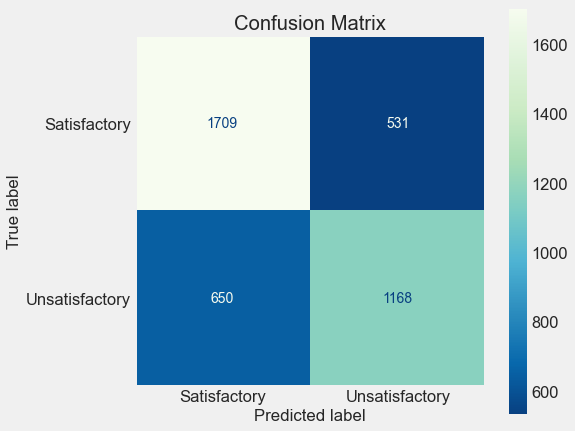

,Accuracy,F1,Recall,Precision
0,0.70897,0.664202,0.642464,0.687463


time: 10.4 s


In [183]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [184]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 986 µs


### Fitting Model

In [185]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 187 ms


In [186]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 754 µs


### Cross Val Scores

In [187]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg ASSESS/MinMax()')

logreg_assess has an average Accuracy of 0.7933946706395874
logreg_assess has an average F1 of 0.7694352151547299
logreg_assess has an average Recall of 0.7692025664527955
logreg_assess has an average Precision of 0.7698416185921375


[0.7933946706395874,
 0.7694352151547299,
 0.7692025664527955,
 0.7698416185921375]

time: 878 ms


### Test Data Confusion Matrix

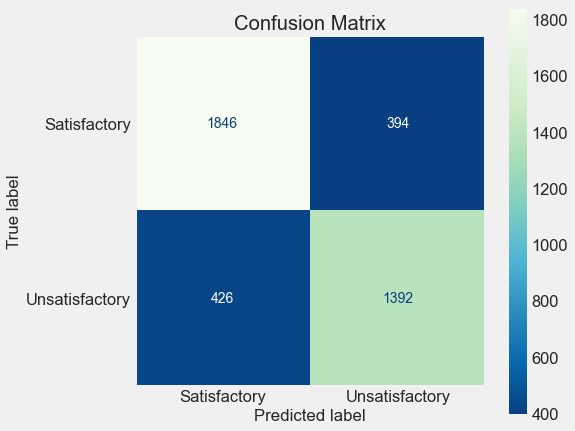

,Accuracy,F1,Recall,Precision
0,0.79793,0.772475,0.765677,0.779395


time: 269 ms


In [188]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [189]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 929 µs


### Fitting Model

In [190]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('svc', SVC())])

time: 6.07 s


In [191]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 662 µs


### Cross Val Scores

In [192]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF ASSESS/MinMax()')

svc_assess has an average Accuracy of 0.7991457095662239
svc_assess has an average F1 of 0.7727184341801244
svc_assess has an average Recall of 0.7620531622364803
svc_assess has an average Precision of 0.783762731133445


[0.7991457095662239, 0.7727184341801244, 0.7620531622364803, 0.783762731133445]

time: 31.4 s


### Test Data Confusion Matrix

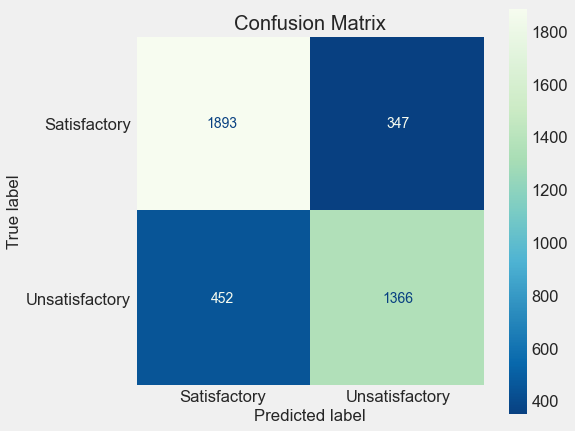

,Accuracy,F1,Recall,Precision
0,0.803105,0.773718,0.751375,0.797431


time: 7.51 s


In [193]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [194]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 963 µs


### Fitting Model

In [195]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('linearsvc', LinearSVC())])

time: 181 ms


In [196]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 681 µs


### Cross Val Scores

In [197]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC ASSESS/MinMax()')

lsvc_assess has an average Accuracy of 0.7919159612538996
lsvc_assess has an average F1 of 0.769052930700562
lsvc_assess has an average Recall of 0.7730522456461962
lsvc_assess has an average Precision of 0.7652459016393444


[0.7919159612538996, 0.769052930700562, 0.7730522456461962, 0.7652459016393444]

time: 919 ms


### Test Data Confusion Matrix

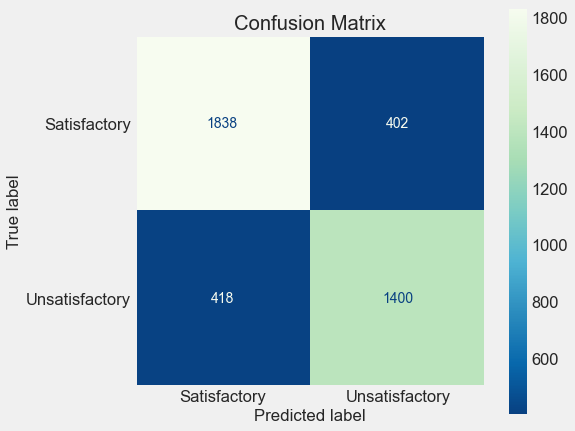

,Accuracy,F1,Recall,Precision
0,0.79793,0.773481,0.770077,0.776915


time: 296 ms


In [198]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [199]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 1.23 ms


### Fitting Model

In [200]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 436 ms


In [201]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 712 µs


### Cross Val Scores

In [202]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF ASSESS/MinMax()')

dt_assess has an average Accuracy of 0.8105642346025419
dt_assess has an average F1 of 0.7894370699929242
dt_assess has an average Recall of 0.7923006416131989
dt_assess has an average Precision of 0.7867764982342063


[0.8105642346025419,
 0.7894370699929242,
 0.7923006416131989,
 0.7867764982342063]

time: 1.76 s


### Test Data Confusion Matrix

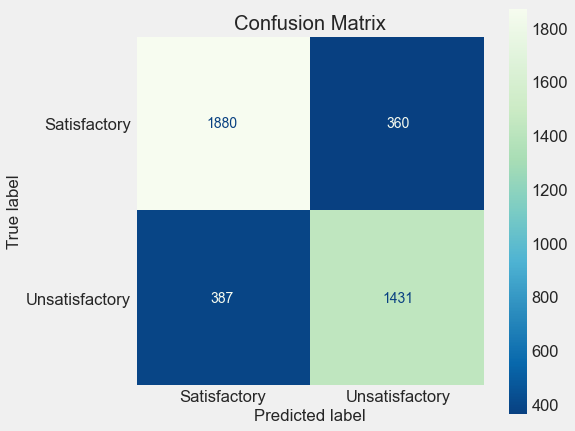

,Accuracy,F1,Recall,Precision
0,0.815919,0.793017,0.787129,0.798995


time: 262 ms


In [203]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [204]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 1.06 ms


### Fitting Model

In [205]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.2 s


In [206]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 679 µs


### Cross Val Scores

In [207]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF ASSESS/MinMax()')

bclf_assess has an average Accuracy of 0.8549247062912638
bclf_assess has an average F1 of 0.8285759845307897
bclf_assess has an average Recall of 0.7824014665444545
bclf_assess has an average Precision of 0.8807122756875296


[0.8549247062912638,
 0.8285759845307897,
 0.7824014665444545,
 0.8807122756875296]

time: 8.34 s


### Test Data Confusion Matrix

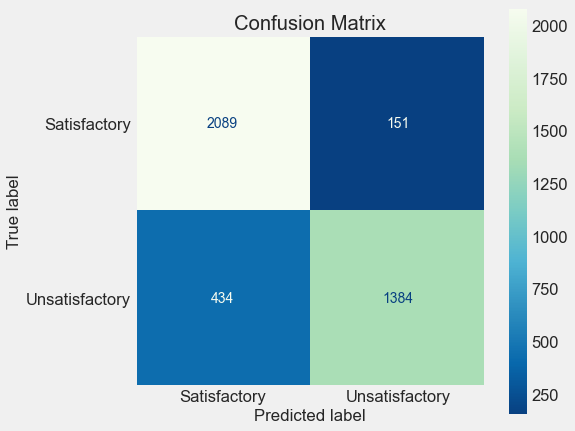

,Accuracy,F1,Recall,Precision
0,0.85584,0.825529,0.761276,0.901629


time: 292 ms


In [208]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [209]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 1.45 ms


### Fitting Model

In [210]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.31 s


In [211]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 794 µs


### Cross Val Scores

In [212]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest ASSESS/MinMax()')

rf_assess has an average Accuracy of 0.8578823275331166
rf_assess has an average F1 of 0.8356587164531962
rf_assess has an average Recall of 0.8064161319890009
rf_assess has an average Precision of 0.867193336844168


[0.8578823275331166, 0.8356587164531962, 0.8064161319890009, 0.867193336844168]

time: 11.8 s


### Test Data Confusion Matrix

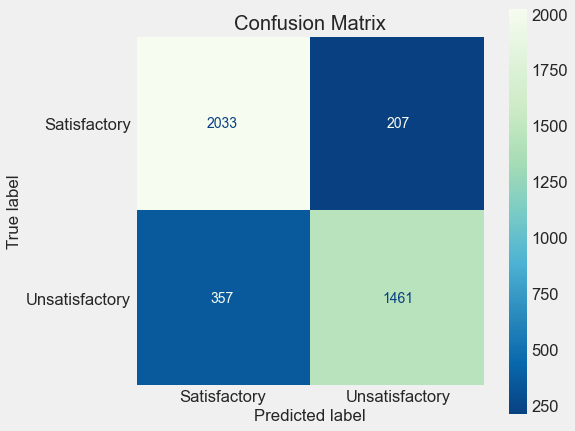

,Accuracy,F1,Recall,Precision
0,0.861015,0.83821,0.80363,0.875899


time: 538 ms


In [213]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [214]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 1.05 ms


### Fitting Model

In [215]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 466 ms


In [216]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 1.03 ms


### Cross Val Scores

In [217]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost ASSESS/MinMax()')

ada_assess has an average Accuracy of 0.8085928470554888
ada_assess has an average F1 of 0.787989837570892
ada_assess has an average Recall of 0.7937671860678277
ada_assess has an average Precision of 0.7824005864328906


[0.8085928470554888, 0.787989837570892, 0.7937671860678277, 0.7824005864328906]

time: 1.5 s


### Test Data Confusion Matrix

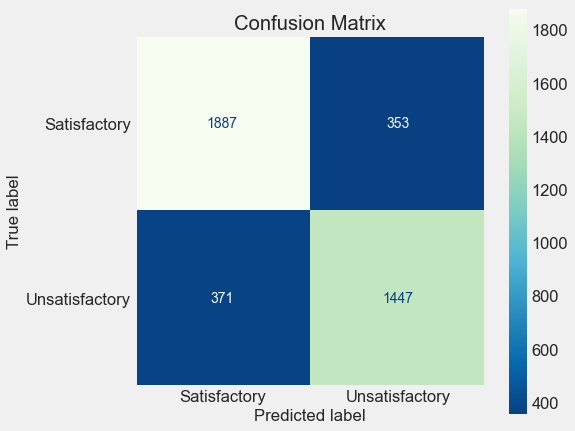

,Accuracy,F1,Recall,Precision
0,0.821587,0.799889,0.79593,0.803889


time: 236 ms


In [218]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [219]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 1.02 ms


### Fitting Model

In [220]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.56 s


In [221]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 891 µs


### Cross Val Scores

In [222]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess',\
                'XGBoost ASSESS/MinMax()')

[0.86092157812239, 0.8383512771268942, 0.8049495875343722, 0.8748990397263995]

time: 8.28 s


### Test Data Confusion Matrix

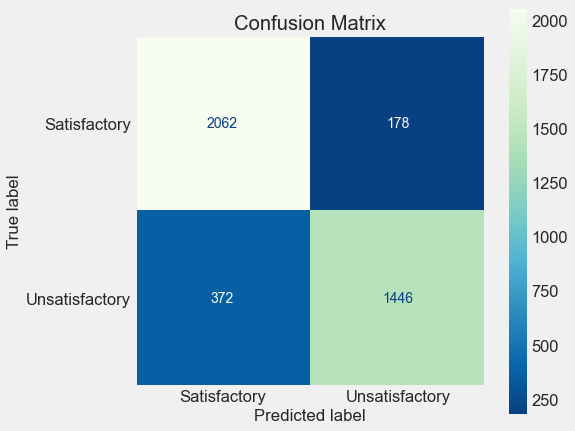

,Accuracy,F1,Recall,Precision
0,0.864465,0.840209,0.79538,0.890394


time: 468 ms


In [223]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [224]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 22.3 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [225]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.48 ms


In [226]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 1.23 ms


### Fitting Model

In [227]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.8 s


In [228]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 818 µs


### Cross Val Scores

In [229]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess',\
                'Voting CLF ASSESS/MinMax()')

[0.8639611999075385, 0.840764621386851, 0.8014665444546287, 0.8842175235709883]

time: 24.9 s


### Test Data Confusion Matrix

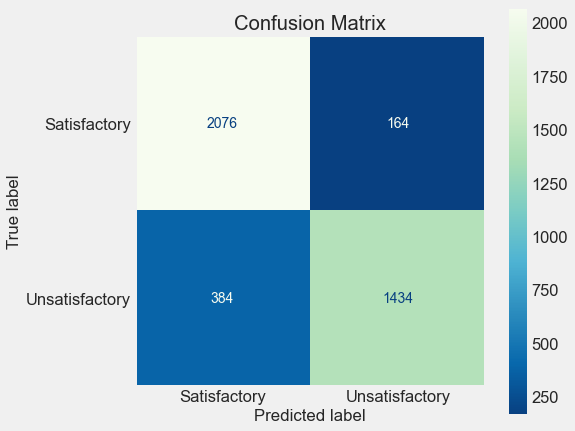

,Accuracy,F1,Recall,Precision
0,0.864958,0.839578,0.788779,0.897372


time: 1.26 s


In [230]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [231]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 24.7 ms


## Neural Network

In [232]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=40, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 3.16 ms


In [233]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 3.04 ms


### Pipeline

In [234]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 1.79 ms


### Fitting Models

In [235]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1d1b37940>)])

time: 9.4 s


### Cross Val Scores

In [236]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net ASSESS/MinMax()')

[0.7948745273579796,
 0.7593803378818687,
 0.7291877807196566,
 0.7973958475591351]

time: 30.3 s


### Test Data Confusion Matrix

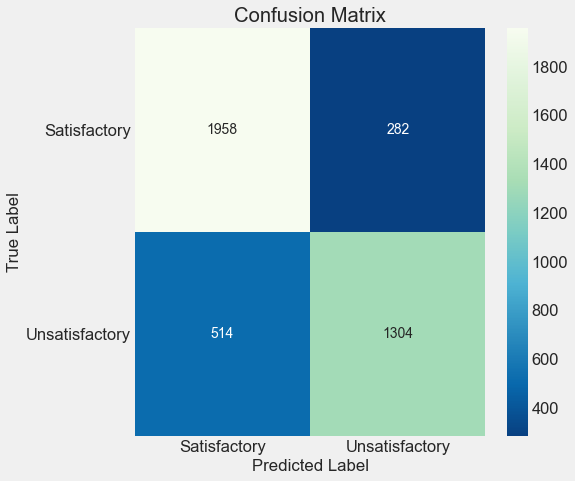

,Accuracy,F1,Recall,Precision
0,0.803844,0.766157,0.717272,0.822194


time: 772 ms


In [237]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [238]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 17 ms


# SS Test

## KNeighborsClassifier

In [239]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 971 µs


### Fitting Model

In [240]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 49.8 ms


In [241]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 709 µs


### Cross Val Scores

In [242]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7850979029120316
knn_ss has an average F1 of 0.7551893265192485
knn_ss has an average Recall of 0.7396883593033914
knn_ss has an average Precision of 0.7714454316058483


[0.7850979029120316,
 0.7551893265192485,
 0.7396883593033914,
 0.7714454316058483]

time: 6.04 s


### Test Data Confusion Matrix

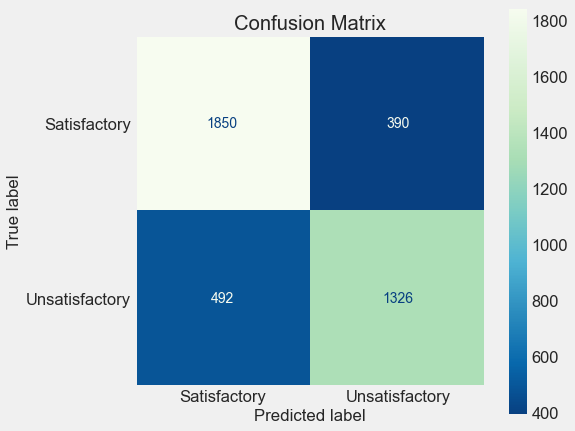

,Accuracy,F1,Recall,Precision
0,0.782652,0.750424,0.729373,0.772727


time: 11.6 s


In [243]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [244]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 906 µs


### Fitting Model

In [245]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 337 ms


In [246]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 870 µs


### Cross Val Scores

In [247]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7934768061632013
logreg_ss has an average F1 of 0.7697176027347478
logreg_ss has an average Recall of 0.7701191567369385
logreg_ss has an average Precision of 0.7694785791887669


[0.7934768061632013,
 0.7697176027347478,
 0.7701191567369385,
 0.7694785791887669]

time: 693 ms


### Test Data Confusion Matrix

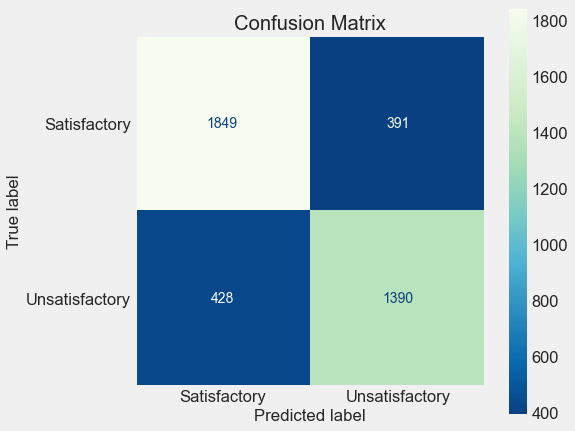

,Accuracy,F1,Recall,Precision
0,0.798176,0.772437,0.764576,0.78046


time: 276 ms


In [248]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [249]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.09 ms


### Fitting Model

In [250]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('svc', SVC())])

time: 7.86 s


In [251]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 903 µs


### Cross Val Scores

In [252]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.8223940784134414
svc_ss has an average F1 of 0.7967472079100381
svc_ss has an average Recall of 0.7770852428964254
svc_ss has an average Precision of 0.817655586065861


[0.8223940784134414, 0.7967472079100381, 0.7770852428964254, 0.817655586065861]

time: 20.4 s


### Test Data Confusion Matrix

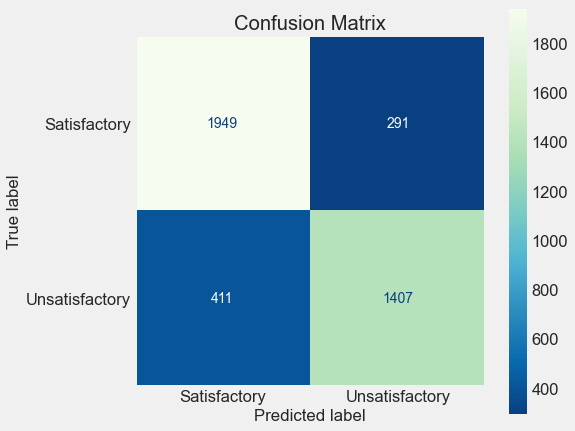

,Accuracy,F1,Recall,Precision
0,0.827008,0.800341,0.773927,0.828622


time: 5.66 s


In [253]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [254]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 863 µs


### Fitting Model

In [255]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('linearsvc', LinearSVC())])

time: 711 ms


In [256]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 589 µs


### Cross Val Scores

In [257]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7920802997912866
lsvc_ss has an average F1 of 0.7691469335478158
lsvc_ss has an average Recall of 0.7728689275893675
lsvc_ss has an average Precision of 0.7656033296261735


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7920802997912866,
 0.7691469335478158,
 0.7728689275893675,
 0.7656033296261735]

time: 2.53 s


### Test Data Confusion Matrix

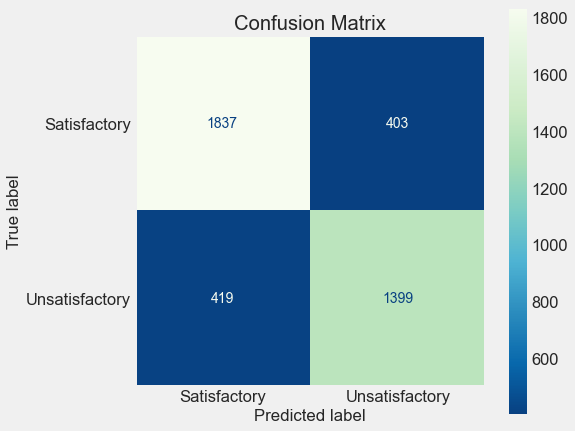

,Accuracy,F1,Recall,Precision
0,0.797437,0.772928,0.769527,0.77636


time: 239 ms


In [258]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [259]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 896 µs


### Fitting Model

In [260]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 454 ms


In [261]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 657 µs


### Cross Val Scores

In [262]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.810974979710771
dt_ss has an average F1 of 0.7899902291452426
dt_ss has an average Recall of 0.793217231897342
dt_ss has an average Precision of 0.7869619592895314


[0.810974979710771, 0.7899902291452426, 0.793217231897342, 0.7869619592895314]

time: 1.55 s


### Test Data Confusion Matrix

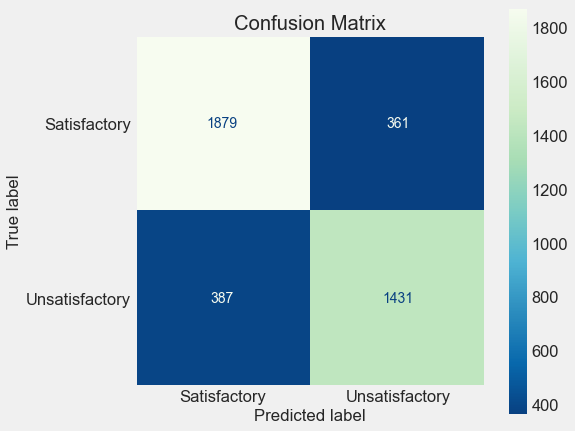

,Accuracy,F1,Recall,Precision
0,0.815673,0.792798,0.787129,0.798549


time: 254 ms


In [263]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [264]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 942 µs


### Fitting Model

In [265]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.25 s


In [266]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 641 µs


### Cross Val Scores

In [267]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.8549246725461843
bclf_ss has an average F1 of 0.828645424583517
bclf_ss has an average Recall of 0.7827681026581119
bclf_ss has an average Precision of 0.8803951467023378


[0.8549246725461843, 0.828645424583517, 0.7827681026581119, 0.8803951467023378]

time: 8.14 s


### Test Data Confusion Matrix

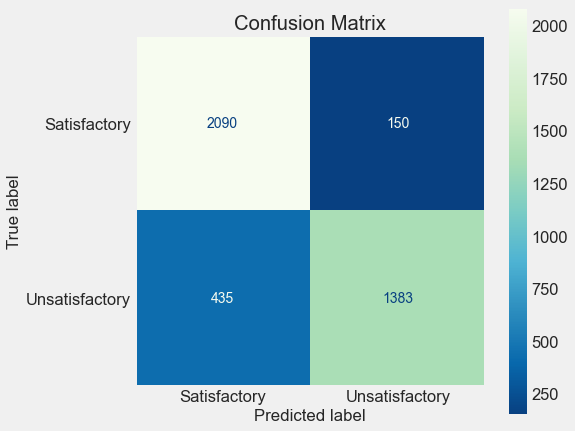

,Accuracy,F1,Recall,Precision
0,0.85584,0.825425,0.760726,0.902153


time: 281 ms


In [268]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [269]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 953 µs


### Fitting Model

In [270]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.83 s


In [271]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 771 µs


### Cross Val Scores

In [272]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.8578001920095026
rf_ss has an average F1 of 0.8355482770304317
rf_ss has an average Recall of 0.8062328139321723
rf_ss has an average Precision of 0.8671661706441498


[0.8578001920095026,
 0.8355482770304317,
 0.8062328139321723,
 0.8671661706441498]

time: 8.23 s


### Test Data Confusion Matrix

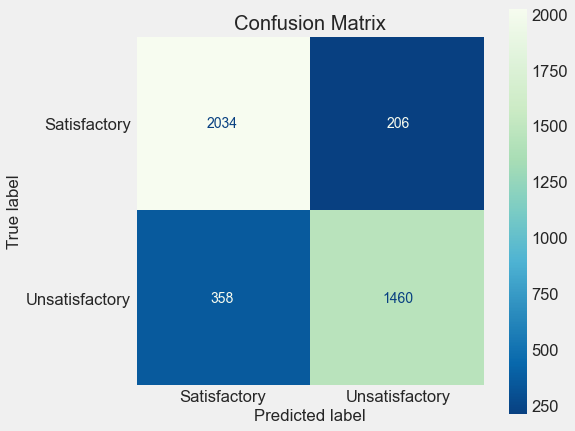

,Accuracy,F1,Recall,Precision
0,0.861015,0.838117,0.80308,0.876351


time: 494 ms


In [273]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [274]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 932 µs


### Fitting Model

In [275]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 490 ms


In [276]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 671 µs


### Cross Val Scores

In [277]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.8090034909284791
ada_ss has an average F1 of 0.7884678909286931
ada_ss has an average Recall of 0.7943171402383135
ada_ss has an average Precision of 0.7828095422788546


[0.8090034909284791,
 0.7884678909286931,
 0.7943171402383135,
 0.7828095422788546]

time: 1.62 s


### Test Data Confusion Matrix

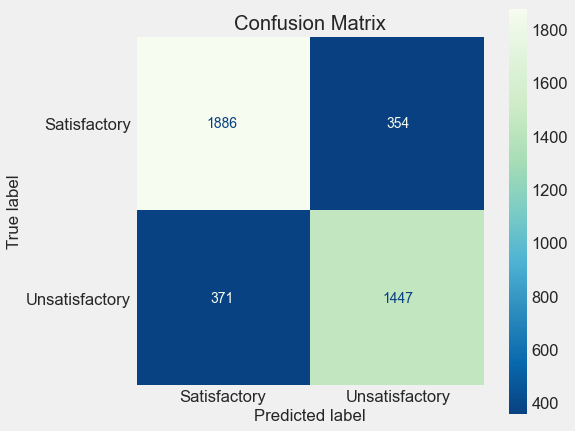

,Accuracy,F1,Recall,Precision
0,0.821341,0.799668,0.79593,0.803443


time: 255 ms


In [278]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [279]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 890 µs


### Fitting Model

In [280]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 870 ms


In [281]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 812 µs


### Cross Val Scores

In [282]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.8594431386973389, 0.836960233121044, 0.8051329055912007, 0.8717277035593003]

time: 4.14 s


### Test Data Confusion Matrix

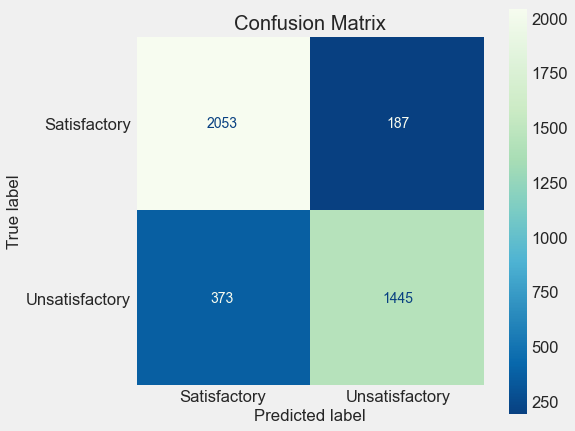

,Accuracy,F1,Recall,Precision
0,0.862001,0.837681,0.794829,0.885417


time: 441 ms


In [283]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [284]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 21.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [285]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.2 ms


In [286]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 879 µs


### Fitting Model

In [287]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.19 s


In [288]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 912 µs


### Cross Val Scores

In [289]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.8620717791587014,
 0.8389334029575236,
 0.8016498625114574,
 0.8799672424453157]

time: 20.2 s


### Test Data Confusion Matrix

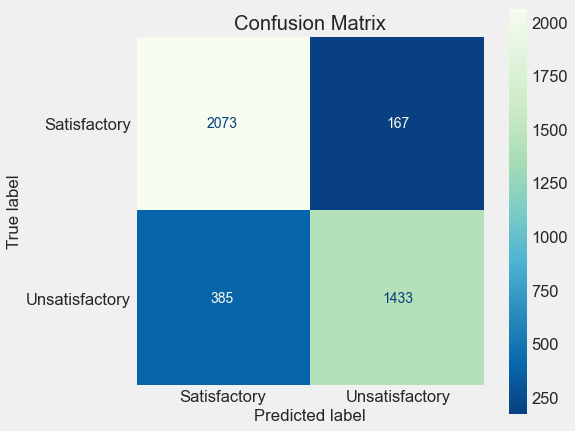

,Accuracy,F1,Recall,Precision
0,0.863972,0.838502,0.788229,0.895625


time: 1.14 s


In [290]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [291]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 14.2 ms


## Neural Network

### Pipeline

In [292]:
nn_ss = make_pipeline(preprocessing_ss, NN2)

time: 921 µs


### Fitting Models

In [293]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02ab80>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c02db80>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1d1b37940>)])

time: 5.2 s


### Cross Val Scores

In [294]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

[0.8381662923774927,
 0.8138790194665424,
 0.7912617442542768,
 0.8431894642454731]

time: 20.7 s


### Test Data Confusion Matrix

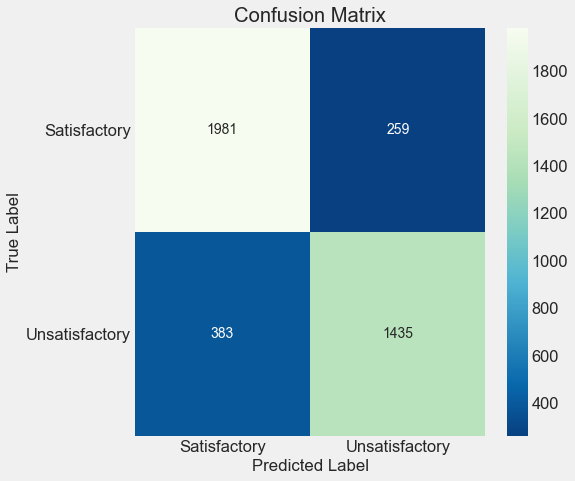

,Accuracy,F1,Recall,Precision
0,0.841794,0.817198,0.789329,0.847107


time: 695 ms


In [295]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [296]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.553202,0.574815,0.568223,0.581733,1.692868,Decision Tree
1,knn,0.547380,0.578151,0.583360,0.573258,10.883734,KNN
2,bclf,0.553202,0.598854,0.627375,0.572959,7.585499,Bagging CLF
3,rf,0.555314,0.600392,0.628341,0.574887,15.947514,Random Forest
4,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.461823,Naive Bayes SVSI/MinMax()
5,mnb_assess,0.692269,0.605126,0.526123,0.712236,0.313700,Naive Bayes ASSESS/MinMax()
6,ada,0.554858,0.605257,0.642083,0.572621,6.051163,AdaBoost
7,xgb,0.562393,0.607038,0.635963,0.580811,5.557646,XGBoost
8,fsm,0.585397,0.630474,0.665164,0.599282,0.369789,FSM Naive Bayes
9,svc,0.586254,0.633351,0.672249,0.598870,83.094996,Support Vector Classifier


time: 22.6 ms


In [297]:
%%capture --no-display
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

time: 1.36 ms
[22:14:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to rest